# Time series forecast with tsfresh feature selection

See https://github.com/blue-yonder/tsfresh/blob/master/notebooks/timeseries_forecasting_basic_example.ipynb

Install tsfresh and use pandas version 0.23.4.

In [ ]:
%matplotlib inline
!pip install tsfresh
!pip install pandas==0.23.4
import numpy as np
import pandas as pd  #pd.show_versions()
import matplotlib.pylab as plt
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

from tsfresh.utilities.dataframe_functions import roll_time_series

import warnings
warnings.filterwarnings('ignore')

# The data

2011-01-01 00:00:00   -0.407331
2011-01-01 01:00:00    0.266966
2011-01-01 02:00:00   -0.103170
2011-01-01 03:00:00    1.293096
2011-01-01 04:00:00    1.303130
Freq: H, dtype: float64


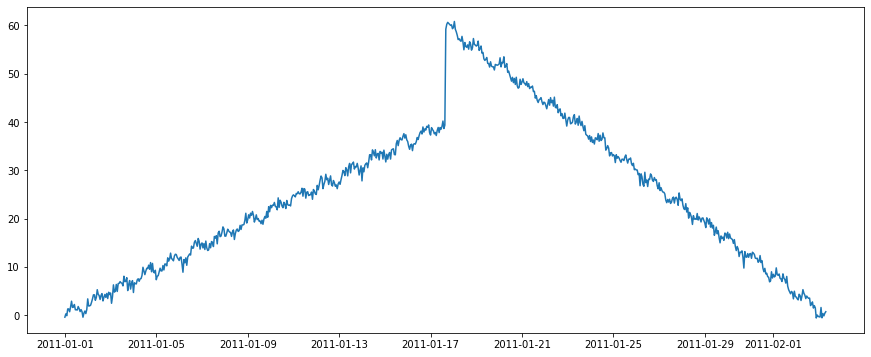

In [2]:
number_points = 400

x_up = np.arange(number_points)*0.1 + np.sin(30*np.pi*np.linspace(0, 1, number_points)) + np.random.normal(scale=0.7,size=number_points)
x_down = np.arange(number_points, 0, -1)*0.15 + np.sin(30*np.pi*np.linspace(0, 1, number_points)) + np.random.normal(scale=0.7,size=number_points)
x = np.concatenate([x_up, x_down])
x = pd.Series(data=x, index=pd.date_range('1/1/2011', periods=len(x), freq='H'))
print(x.head())
plt.figure(figsize=(15, 6))
plt.plot(x)
plt.show()

In [3]:
df = pd.DataFrame(x)
df.reset_index(inplace=True)
df.columns = ["time", "value"]
df["kind"] = "a"
df["id"] = 1

df.head()

,time,value,kind,id
0,2011-01-01 00:00:00,-0.407331,a,1
1,2011-01-01 01:00:00,0.266966,a,1
2,2011-01-01 02:00:00,-0.103170,a,1
3,2011-01-01 03:00:00,1.293096,a,1
4,2011-01-01 04:00:00,1.303130,a,1


#Feature selection and x_train, y_train

First we extract features, which will gives us x_train, i.e. for every date we obtain (some hundreds of) features.

In [4]:

max_timeshift = 20
df_shift, y = make_forecasting_frame(x, kind="price", max_timeshift=max_timeshift, rolling_direction=1)

X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, show_warnings=False)

X.head()

Feature Extraction: 100%|██████████| 5/5 [00:56<00:00, 11.23s/it]


value__variance_larger_than_standard_deviation                       ...                        value__permutation_entropy__dimension_7__tau_1
id 2011-01-01 01:00:00                                             0.0                       ...                                                              2.639057
   2011-01-01 02:00:00                                             0.0                       ...                                                              2.639057
   2011-01-01 03:00:00                                             0.0                       ...                                                              2.639057
   2011-01-01 04:00:00                                             0.0                       ...                                                              2.639057
   2011-01-01 05:00:00                                             0.0                       ...                                                              2.639057

[5 rows x 779 columns]

In [5]:
print(X.head())
y.head()

                        value__variance_larger_than_standard_deviation                       ...                        value__permutation_entropy__dimension_7__tau_1
id 2011-01-01 01:00:00                                             0.0                       ...                                                              2.639057
   2011-01-01 02:00:00                                             0.0                       ...                                                              2.639057
   2011-01-01 03:00:00                                             0.0                       ...                                                              2.639057
   2011-01-01 04:00:00                                             0.0                       ...                                                              2.639057
   2011-01-01 05:00:00                                             0.0                       ...                                                              2.63905

2011-01-01 01:00:00    0.266966
2011-01-01 02:00:00   -0.103170
2011-01-01 03:00:00    1.293096
2011-01-01 04:00:00    1.303130
2011-01-01 05:00:00    0.715711
Freq: H, Name: value, dtype: float64

In [6]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

print("Number of non-constant features: " + str(X.shape[1]))

(799, 779)
(799, 370)
Number of non-constant features: 370


Now we define x_train and y_train.

In [7]:
# y_train is obtained from x by a shift of 'n_shift' points into the future.
# n_shift = 1 corresponds to y_train = y
n_shift = 5
y_train = np.zeros(len(x)-n_shift)
for j in range(len(y_train)):
    y_train[j] = x[j+n_shift]
    
y_train = pd.Series(data=y_train, index=x.index[0:len(x)-n_shift])    
 
x_train = np.zeros((len(x)-n_shift, X.shape[1]))

for j in range(len(x_train)):
    for k in range(X.shape[1]):
        x_train[j,k] = X.iloc[j,k]

#Model 1: A trivial forecast


In [8]:
y_shift = y.shift(n_shift)
for j in range(n_shift):
    y_shift[j] = y_train.iloc[j]
y_shift = pd.Series(data=y_shift, index=y_train.index)

print("Example: true value at " + str(y_train.index[30]) + "= " + str(y_train[30]) + ", shift forecast = " + str(y_shift[30]))

Example: true value at 2011-01-02 06:00:00= 3.08401485169592, shift forecast = 2.6637712441146553


#Model 2: AdaBoostRegressor on the features

In [9]:
ada = AdaBoostRegressor()

y_ada = [0] * len(y_train)
y_ada[0] = y_train.iloc[0]

for i in range(1, len(y_train)):
    ada.fit(X.iloc[:i], y_train.iloc[:i])
    y_ada[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))
    
y_ada = pd.Series(data=y_ada, index=y_train.index)

for j in range(1,len(y_ada)):
    y_ada.iloc[j] = y_ada.iloc[j][0]
    
print("Example: true value at " + str(y_train.index[30]) + "= " + str(y_train[30]) + ", AdaBoost forecast = " + str(y_ada[30]))

KeyboardInterrupt: ignored

#Model 3: A neuronal network on the features

We first define the model via keras (tensorflow):

In [ ]:
import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential

model = Sequential()

# The input layer requires the special input_shape parameter which should match
# the shape of our training data.
model.add(Dense(units=400, activation='sigmoid', use_bias=True, input_shape=(X.shape[1],)))
model.add(Dropout(0.25))
model.add(Dense(units=100, activation='relu', use_bias=True))
model.add(Dropout(0.25))
model.add(Dense(units=400, activation='sigmoid', use_bias=True))
model.add(Dense(units=1, use_bias=True, activation='linear'))
model.summary()

Now we train the model:

In [ ]:
model.compile(optimizer=keras.optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=None, decay=0.0), loss='mean_squared_error', metrics=['mean_absolute_error'])
#model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=100, epochs=10000, verbose=False, validation_split=.1)
loss, accuracy  = model.evaluate(x_train, y_train, verbose=False)

plt.plot(history.history['mean_absolute_error'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Iteration')
plt.legend(['Training'], loc='best')
plt.show()

#print(f'Test loss: {loss:.3}')
#print(f'Training mean absolute error: {accuracy:.3}')

y_ANN = model.predict(x_train)
y_ANN2 = np.zeros((len(y_ANN)))
y_ANN[0] = y.iloc[0]
for j in range(len(y_ANN)):
    y_ANN2[j] = y_ANN[j][0]
y_ANN = pd.Series(data=y_ANN2, index=y_train.index)

print("Example: true value at " + str(y_train.index[30]) + "= " + str(y_train[30]) + ", ANN forecast = " + str(y_ANN[30]))

# The results

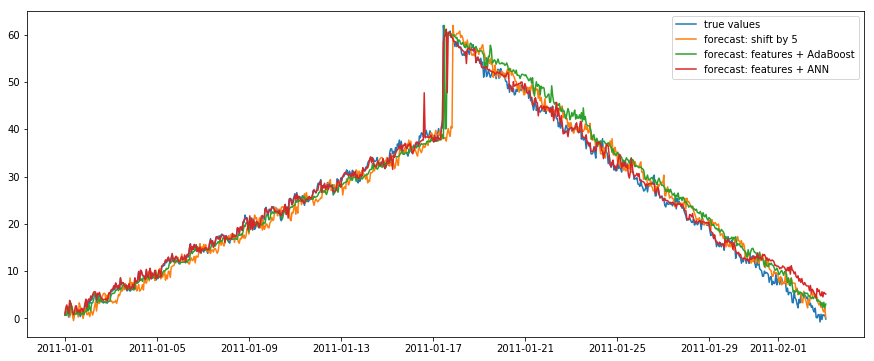

Mean absolute errors:

MAE y_shift: 	1.983159632369186
MAE ada: 	1.7910235255365488
MAE ANN: 	0.8871989872322895


In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(y_train, label="true values")
plt.plot(y_shift, label="forecast: shift by " + str(n_shift))
plt.plot(y_ada, label="forecast: features + AdaBoost")
plt.plot(y_ANN, label="forecast: features + ANN")
plt.legend()
plt.show()

print("Mean absolute errors:\n")
print("MAE y_shift: \t{}".format(np.mean(np.abs(y_shift - y_train)[0:] )))
print("MAE ada: \t{}".format(np.mean(np.abs(y_ada - y_train)[0:])))
print("MAE ANN: \t{}".format(np.mean(np.abs(y_ANN - y_train)[0:])))